In [1]:
import numpy as np
import pandas as pd
import pymysql
import json

In [2]:
def get_mysql_credentials():
        with open("mysql_config.json", "r") as jsonfile:
            data = json.load(jsonfile)
        return (data['host'], data['user'], data['password'], data['database'])
    
def get_cursor():
    creds = get_mysql_credentials()
    dbinstance_endpoint = creds[0]
    db_username = creds[1]
    db_pw = creds[2]
    db_name = creds[3]
    connection = pymysql.connect(host = dbinstance_endpoint, user = db_username, password = db_pw, database = db_name, autocommit=True)
    cursor = connection.cursor()
    return cursor

cursor = get_cursor()

In [38]:
import ast
from datetime import datetime, timedelta, date

In [4]:
import bisect

In [52]:
from matplotlib import pyplot as plt

In [18]:
def calc_orderboook_imb(bids, asks, level=1):
    '''
    bids: ascending [price, qty] list
    asks: ascending [price, qty] list
    level: depth of orderbook for which to calculate order book imbalance
    '''
    bids_depth = len(bids)
    asks_depth = len(asks)
    if level > min([bids_depth, asks_depth]) or level == 0:
        if level <= 1:
            if bids_depth:
                return 1
            elif asks_depth:
                return -1
            else:
                return 0
        return calc_orderboook_imb(bids, asks, min([bids_depth, asks_depth]))
    else:
        bids_vol = 0
        asks_vol = 0
        for idx in range(level):
            bids_vol += bids[len(bids)-1-idx][1]
            asks_vol += asks[idx][1]
        return (bids_vol - asks_vol)/(bids_vol + asks_vol)

In [6]:
def get_best_bid(bids):
    '''
    bids: ascending [price, qty] list
    '''
    if len(bids):
        return bids[len(bids)-1][0]
    else:
        return 0

def get_best_ask(asks):
    '''
    asks: ascending [price, qty] list
    '''
    if len(asks):
        return asks[0][0]
    else:
        return np.inf

    

In [7]:
def update_bids(bids, price, delta):
    '''
    bids: ascending [price, qty] list
    price: price level at which delta qty is being added to or removed
    delta: contracts being placed or removed from a price level
    '''
    bisect_left_ip = bisect.bisect_left(bids, price, key = lambda x: x[0])
    if bisect_left_ip == len(bids):
        #price is greater than all of the bids
        assert delta > 0
        bids.insert(bisect_left_ip, [price, delta])
        
    else:
        #price is greater than bids[:bisect_left_ip]
        if bids[bisect_left_ip][0] == price:
            #price exists in the current bids
            bids[bisect_left_ip][1]+=delta #update qty
            if bids[bisect_left_ip][1] <= 0:
                #remove price leveel
                del bids[bisect_left_ip]
        else:
            #price does not exist in the current bids
            assert delta > 0
            bids.insert(bisect_left_ip, [price, delta])

def update_asks(asks, price, delta):
    '''
    asks: ascending [price, qty] list
    price: price level at which delta qty is being added to or removed
    delta: contracts being placed or removed from a price level
    '''
    bisect_left_ip = bisect.bisect_left(asks, price, key = lambda x: x[0])
    if bisect_left_ip == len(asks):
        #price is greater than all of the asks
        assert delta > 0
        asks.insert(bisect_left_ip, [price, delta])
        
    else:
        #price is greater than asks[:bisect_left_ip]
        if asks[bisect_left_ip][0] == price:
            #price exists in the current bids
            asks[bisect_left_ip][1]+=delta #update qty
            if asks[bisect_left_ip][1] <= 0:
                #remove price leveel
                del asks[bisect_left_ip]
        else:
            #price does not exist in the current bids
            assert delta > 0
            asks.insert(bisect_left_ip, [price, delta])
    
            
    

In [39]:
date.today()

datetime.date(2024, 1, 30)

In [47]:
'''

Loops through 2024 dates and queries all of the orderbook delta messages (for all NDX and SPX range markets on Kalshi) occuring on that date that 
I have stored in a MySQL DB. Loops through each orderbook delta on a given day and updates a local state of 
the limit orderbook for that market. Appends to a dataframe, the best bid, ask, orderbook imbalance, and midprice after each delta is processed.

'''


bids = {}
asks = {}
data_dict = {'best_bid': [], 'best_ask': [], 'obi_l1': [], 'obi_l2': [], 'obi_l3': [], 'obi_l4': [], 'ticker': [], 'timestamp': []}
date_ = date(2024, 1, 2)

while date_ <= date.today():
    
    #find number of commands
    cursor.execute('select count(distinct(command_id)) from ob_snapshot where processed_ts like \'%{}%\''.format(date_.isoformat()))
    rows = cursor.fetchall()
    num_cmd_ids = None
    
    if rows is not None and len(rows) > 0:
        num_cmd_ids = rows[0][0]
    if num_cmd_ids is None:
        continue
    
    for cmd_id in range(1,num_cmd_ids+1):
        cursor.execute('select * from ob_snapshot where command_id = {} and processed_ts like \'%{}%\' order by processed_ts asc'.format(cmd_id, date_.isoformat()))
        snapshot_rows = cursor.fetchall()
        cursor.execute('select max(seq_num) from ob_snapshot where command_id = {} and processed_ts like \'%{}%\''.format(cmd_id, date_.isoformat()))
        max_seqnum = cursor.fetchall()[0][0]
        
        if max_seqnum != len(snapshot_rows):
            continue
            
        for row in snapshot_rows:
            t = row[2]
            try:
                bids_dict = ast.literal_eval(row[3])
                asks_dict = ast.literal_eval(row[4])
            except:
                continue
            bids_list = []
            asks_list = []
            for p, q in bids_dict.items():
                bids_list.append([p, q])
            for p, q in asks_dict.items():
                asks_list.append([p, q])
            
            bids_list.sort(key = lambda x:x[0])
            asks_list.sort(key = lambda x:x[0])
            
            bids[t] = bids_list[:]
            asks[t] = asks_list[:]
            
            data_dict['best_bid'].append(get_best_bid(bids[t]))
            data_dict['best_ask'].append(get_best_ask(asks[t]))
            data_dict['obi_l1'].append(calc_orderboook_imb(bids[t], asks[t], 1))
            data_dict['obi_l2'].append(calc_orderboook_imb(bids[t], asks[t], 2))
            data_dict['obi_l3'].append(calc_orderboook_imb(bids[t], asks[t], 3))
            data_dict['obi_l4'].append(calc_orderboook_imb(bids[t], asks[t], 4))
            data_dict['ticker'].append(t)
            data_dict['timestamp'].append(datetime.strptime(row[5], '%Y-%m-%dT%H:%M:%S.%fZ'))
        
        cursor.execute('select * from ob_delta where command_id = {} and processed_ts like \'%{}%\' order by processed_ts asc'.format(cmd_id, date_.isoformat()))
        delta_rows = cursor.fetchall()
        for row in delta_rows:
            t = row[2]
            price = row[3]
            delta = row[4]
            side = row[5]
            
            if side == 'yes':
                #bid
                if t in bids:
                    update_bids(bids[t], price, delta)
                else:
                    continue
            else:
                #ask
                if t in asks:
                    update_asks(asks[t], price, delta)
                else:
                    continue
            
            
            data_dict['best_bid'].append(get_best_bid(bids[t]))
            data_dict['best_ask'].append(get_best_ask(asks[t]))
            data_dict['obi_l1'].append(calc_orderboook_imb(bids[t], asks[t], 1))
            data_dict['obi_l2'].append(calc_orderboook_imb(bids[t], asks[t], 2))
            data_dict['obi_l3'].append(calc_orderboook_imb(bids[t], asks[t], 3))
            data_dict['obi_l4'].append(calc_orderboook_imb(bids[t], asks[t], 4))
            data_dict['ticker'].append(t)
            data_dict['timestamp'].append(datetime.strptime(row[6], '%Y-%m-%dT%H:%M:%S.%fZ'))
    
    date_+=timedelta(days=1)      
            

data = pd.DataFrame(data_dict)

In [49]:
data['midprice'] = data.apply(lambda x: (x['best_bid'] + x['best_ask'])/2, axis = 1)

In [51]:
data

,best_bid,best_ask,obi_l1,obi_l2,obi_l3,obi_l4,ticker,timestamp,midprice
0,0,2.0,-1.000000,-1.000000,-1.000000,-1.000000,INXD-24JAN03-B4662,2024-01-03 20:15:48.494189,1.0
1,11,13.0,-0.733333,-0.691057,-0.668712,-0.644670,INXD-24JAN03-B4687,2024-01-03 20:15:48.506276,12.0
2,72,75.0,-0.739130,-0.600000,-0.516129,-0.680136,INXD-24JAN03-B4712,2024-01-03 20:15:48.513190,73.5
3,11,12.0,-0.652174,-0.555950,-0.291856,-0.041989,INXD-24JAN03-B4737,2024-01-03 20:15:48.523760,11.5
4,0,1.0,-1.000000,-1.000000,-1.000000,-1.000000,INXD-24JAN03-B4762,2024-01-03 20:15:48.537417,0.5
...,...,...,...,...,...,...,...,...,...
630329,42,52.0,0.200000,0.250000,0.166667,0.125000,INX-24JAN30-B4912,2024-01-30 20:58:27.113487,47.0
630330,42,52.0,0.200000,0.250000,0.166667,0.125000,INX-24JAN30-B4912,2024-01-30 20:58:27.113525,47.0
630331,42,52.0,0.200000,0.250000,0.166667,0.125000,INX-24JAN30-B4912,2024-01-30 20:58:27.113549,47.0
630332,44,56.0,0.904762,0.023256,0.393258,0.207101,INX-24JAN30-B4937,2024-01-30 20:58:27.113571,50.0


In [61]:
tickers = list(data['ticker'].unique()) #unique tickers in data df
gpo = data.groupby('ticker') #groupby object of data df on ticker


In [67]:
'''
After specifying a lookahead period, this code, for each ticker, finds the correlation betweeen L1, 2, and 3
orderbook imbalance values and the midprice return after lookahead period delta messages related to the ticker.
The data is stored in a dataframe
'''

lookahead_period = 5
corr_dict = {'ticker': [], 'l1_corr': [], 'l2_corr': [], 'l3_corr': []}
for ticker in tickers:
    group = gpo.get_group(ticker)
    group = group.reset_index(drop=True)
    
    if group.shape[0] < 200:
        continue
    
    
    midprice = group['midprice'].tolist()
    obi_l1 = group['obi_l1'].tolist()[:len(midprice)-lookahead_period]
    obi_l2 = group['obi_l2'].tolist()[:len(midprice)-lookahead_period]
    obi_l3 = group['obi_l3'].tolist()[:len(midprice)-lookahead_period]
    midprice_return = (np.array(midprice[lookahead_period:])-np.array(midprice[:len(midprice)-lookahead_period]))/np.array(midprice[:len(midprice)-lookahead_period])
    
    l1_corr = np.corrcoef(obi_l1, midprice_return)[0,1]
    l2_corr = np.corrcoef(obi_l2, midprice_return)[0,1]
    l3_corr = np.corrcoef(obi_l3, midprice_return)[0,1]
    
    corr_dict['ticker'].append(ticker)
    corr_dict['l1_corr'].append(l1_corr)
    corr_dict['l2_corr'].append(l2_corr)
    corr_dict['l3_corr'].append(l3_corr)
    
corr_df = pd.DataFrame(data=corr_dict)
    


/var/folders/8r/fr9y19j57554vvz5607f_l4h0000gn/T/ipykernel_94423/3645188170.py:21: RuntimeWarning: invalid value encountered in subtract
  midprice_return = (np.array(midprice[lookahead_period:])-np.array(midprice[:len(midprice)-lookahead_period]))/np.array(midprice[:len(midprice)-lookahead_period])
/var/folders/8r/fr9y19j57554vvz5607f_l4h0000gn/T/ipykernel_94423/3645188170.py:21: RuntimeWarning: invalid value encountered in divide
  midprice_return = (np.array(midprice[lookahead_period:])-np.array(midprice[:len(midprice)-lookahead_period]))/np.array(midprice[:len(midprice)-lookahead_period])
/Users/irfanjamil/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2698: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/irfanjamil/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/irfanjamil/anaconda3/lib/python3.10/site-packages/numpy/lib/func

In [65]:
corr_df[:-20]

,ticker,l1_corr,l2_corr,l3_corr
0,INXD-24JAN03-B4687,0.158504,0.122299,0.112866
1,INXD-24JAN03-B4712,NaN,NaN,NaN
2,INXD-24JAN03-B4737,0.142141,0.155573,0.153260
3,NASDAQ100D-24JAN03-B16450,0.002710,-0.001222,-0.007565
4,NASDAQ100D-24JAN03-T16400,NaN,NaN,NaN
5,INXD-24JAN04-B4687,NaN,NaN,NaN
6,INXD-24JAN04-B4712,-0.015346,-0.050355,-0.066385
7,NASDAQ100D-24JAN04-B16250,NaN,NaN,NaN
8,NASDAQ100D-24JAN04-B16350,0.080454,0.061061,0.041229
9,INXD-24JAN05-B4662,0.130083,0.052958,0.020267


In [66]:
corr_df.describe()

,l1_corr,l2_corr,l3_corr
count,52.000000,52.000000,52.000000
mean,0.042952,0.033769,0.021914
std,0.103378,0.105382,0.103105
min,-0.217228,-0.217228,-0.217228
25%,-0.004725,-0.037505,-0.055293
50%,0.060396,0.052573,0.024485
75%,0.115103,0.113556,0.104160
max,0.208529,0.204412,0.197367


hard to claim that orderbook imbalance values are correlated with future midprice returns at all

In [74]:
data[data['ticker']==sp500_ticker]

,best_bid,best_ask,obi_l1,obi_l2,obi_l3,obi_l4,ticker,timestamp,midpoint
7273,19,22,0.600000,0.212121,0.122020,0.095290,INX-24JAN29-B4937,2024-01-29 20:15:48.068601+00:00,20.5
7274,19,22,0.600000,0.212121,0.122020,0.095290,INX-24JAN29-B4937,2024-01-29 20:15:49.076958+00:00,20.5
7275,20,22,0.454545,0.212121,0.055807,0.095290,INX-24JAN29-B4937,2024-01-29 20:15:49.097656+00:00,21.0
7276,20,22,0.454545,0.212121,0.055807,0.095290,INX-24JAN29-B4937,2024-01-29 20:15:49.197956+00:00,21.0
7277,20,22,0.454545,0.212121,0.055807,0.095290,INX-24JAN29-B4937,2024-01-29 20:15:49.517759+00:00,21.0
...,...,...,...,...,...,...,...,...,...
22029,55,62,0.326599,-0.200000,-0.114827,-0.169591,INX-24JAN29-B4937,2024-01-29 20:56:12.103928+00:00,58.5
22030,55,62,0.326599,-0.200000,-0.114827,-0.169591,INX-24JAN29-B4937,2024-01-29 20:56:12.103991+00:00,58.5
22031,55,62,0.326599,-0.200000,-0.250000,-0.166667,INX-24JAN29-B4937,2024-01-29 20:56:12.104054+00:00,58.5
22032,55,62,0.326599,-0.200000,-0.250000,-0.166667,INX-24JAN29-B4937,2024-01-29 20:56:12.104114+00:00,58.5


In [23]:
sp500_l1_obi = data[data['ticker']==sp500_ticker]['obi_l1'].tolist()
sp500_l2_obi = data[data['ticker']==sp500_ticker]['obi_l2'].tolist()
sp500_l3_obi = data[data['ticker']==sp500_ticker]['obi_l3'].tolist()
sp500_l4_obi = data[data['ticker']==sp500_ticker]['obi_l4'].tolist()
sp500_midpoint = data[data['ticker']==sp500_ticker]['midpoint'].tolist()

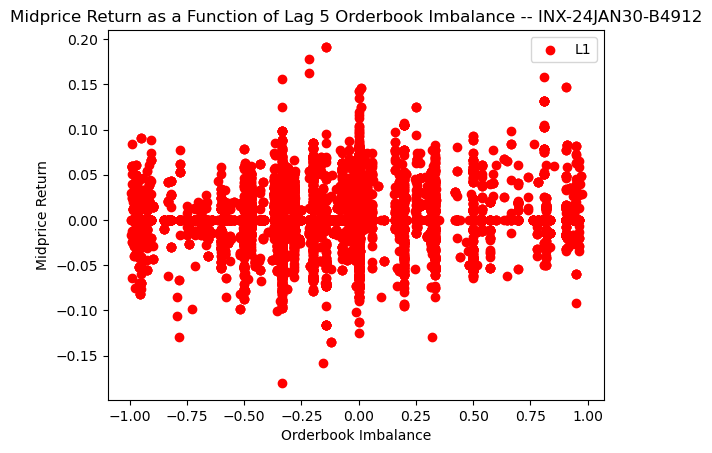

In [24]:
for lookahead_period in [5]:#, 10, 15, 20, 25]:
    plt.figure()
    l1_x = sp500_l1_obi[:len(sp500_midpoint)-lookahead_period]
    y = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    plt.scatter(l1_x, y, color='red', label = 'L1')
    #plt.scatter(l2_x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} Orderbook Imbalance -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()

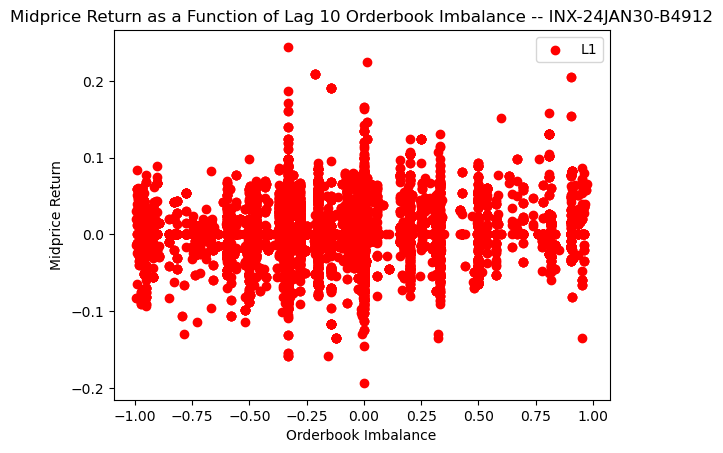

In [25]:
for lookahead_period in [10]:#, 10, 15, 20, 25]:
    plt.figure()
    l1_x = sp500_l1_obi[:len(sp500_midpoint)-lookahead_period]
    y = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    plt.scatter(l1_x, y, color='red', label = 'L1')
    #plt.scatter(l2_x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} Orderbook Imbalance -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()

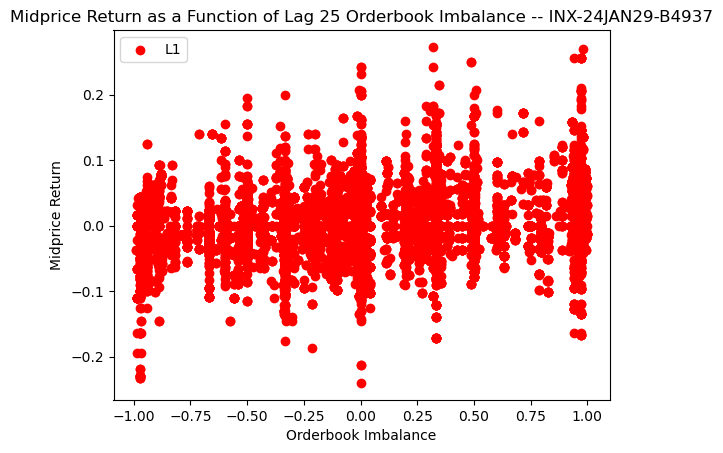

In [91]:
for lookahead_period in [25]:#, 10, 15, 20, 25]:
    plt.figure()
    l1_x = sp500_l1_obi[:len(sp500_midpoint)-lookahead_period]
    l2_x = sp500_l2_obi[:len(sp500_midpoint)-lookahead_period]
    l3_x = sp500_l3_obi[:len(sp500_midpoint)-lookahead_period]
    l4_x = sp500_l4_obi[:len(sp500_midpoint)-lookahead_period]
    y = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    plt.scatter(l1_x, y, color='red', label = 'L1')
    #plt.scatter(l2_x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} Orderbook Imbalance -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()

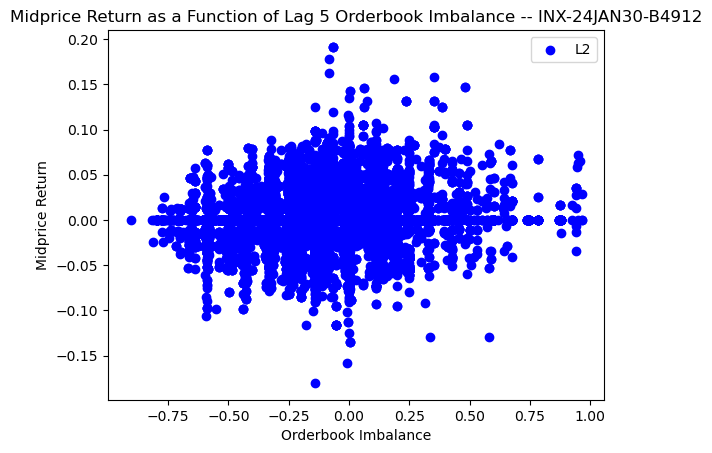

In [27]:
for lookahead_period in [5]:#, 10, 15, 20, 25]:
    plt.figure()
    l2_x = sp500_l2_obi[:len(sp500_midpoint)-lookahead_period]
    y = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    #plt.scatter(l1_x, y, color='red', label = 'L1')
    plt.scatter(l2_x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} Orderbook Imbalance -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()

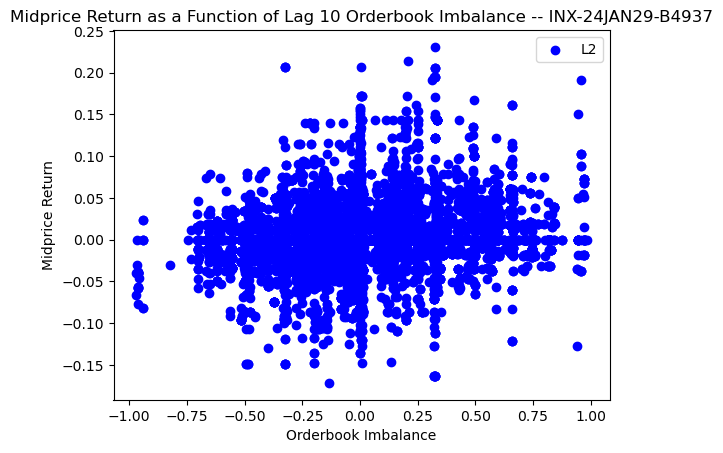

In [94]:
for lookahead_period in [10]:#, 10, 15, 20, 25]:
    plt.figure()
    l1_x = sp500_l1_obi[:len(sp500_midpoint)-lookahead_period]
    l2_x = sp500_l2_obi[:len(sp500_midpoint)-lookahead_period]
    l3_x = sp500_l3_obi[:len(sp500_midpoint)-lookahead_period]
    l4_x = sp500_l4_obi[:len(sp500_midpoint)-lookahead_period]
    y = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    #plt.scatter(l1_x, y, color='red', label = 'L1')
    plt.scatter(l2_x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} Orderbook Imbalance -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()

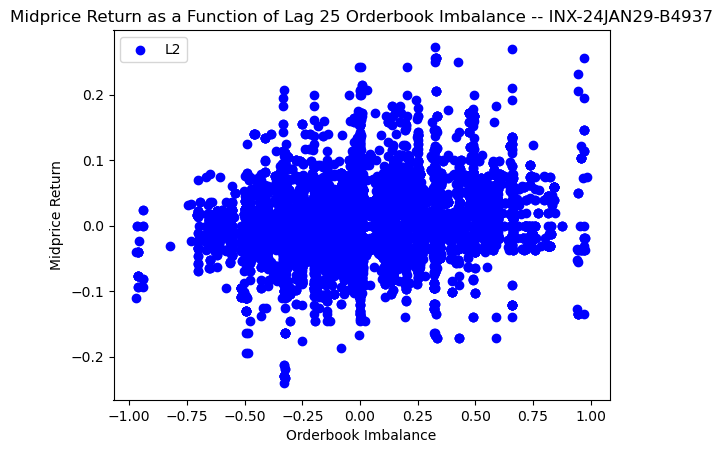

In [95]:
for lookahead_period in [25]:#, 10, 15, 20, 25]:
    plt.figure()
    l1_x = sp500_l1_obi[:len(sp500_midpoint)-lookahead_period]
    l2_x = sp500_l2_obi[:len(sp500_midpoint)-lookahead_period]
    l3_x = sp500_l3_obi[:len(sp500_midpoint)-lookahead_period]
    l4_x = sp500_l4_obi[:len(sp500_midpoint)-lookahead_period]
    y = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    #plt.scatter(l1_x, y, color='red', label = 'L1')
    plt.scatter(l2_x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} Orderbook Imbalance -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()

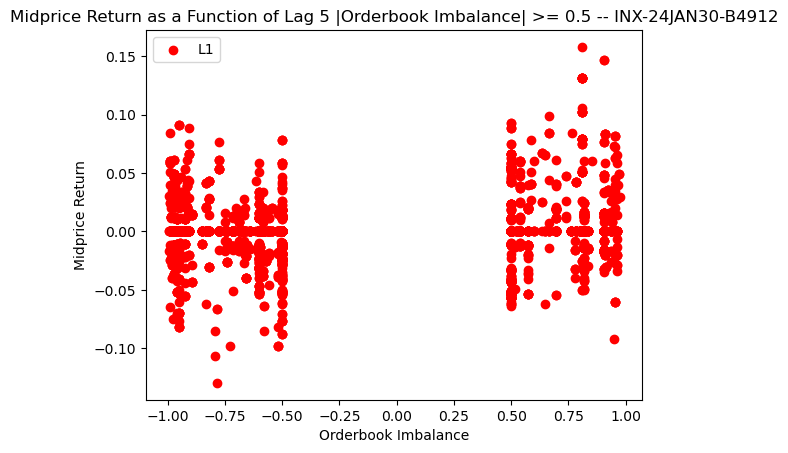

[[1.         0.09062738]
 [0.09062738 1.        ]]


In [28]:
for lookahead_period in [5]:#, 10, 15, 20, 25]:
    plt.figure()
    l1_x_temp = sp500_l1_obi[:len(sp500_midpoint)-lookahead_period]
    y_temp = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    x = []
    y = []
    
    for i in range(len(l1_x_temp)):
        if abs(l1_x_temp[i]) >= 0.5:
            x.append(l1_x_temp[i])
            y.append(y_temp[i])
    
    plt.scatter(x, y, color='red', label = 'L1')
    #plt.scatter(l2_x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} |Orderbook Imbalance| >= 0.5 -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()
    

    print(np.corrcoef(x, y))

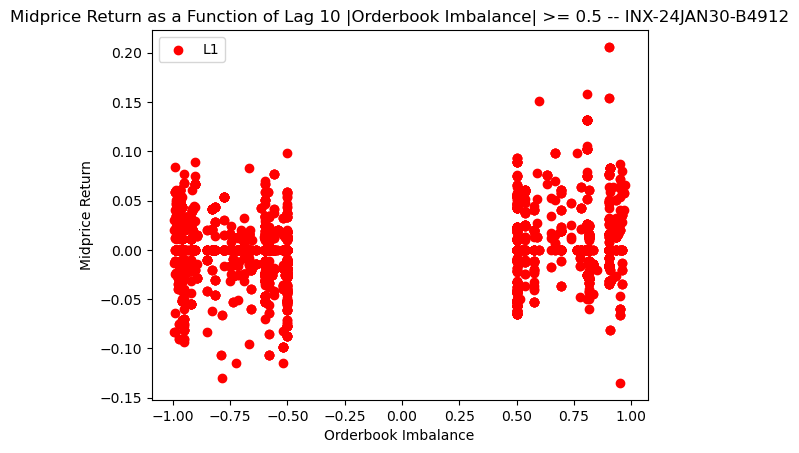

[[1.         0.11885053]
 [0.11885053 1.        ]]


In [29]:
for lookahead_period in [10]:#, 10, 15, 20, 25]:
    plt.figure()
    l1_x_temp = sp500_l1_obi[:len(sp500_midpoint)-lookahead_period]
    y_temp = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    x = []
    y = []
    
    for i in range(len(l1_x_temp)):
        if abs(l1_x_temp[i]) >= 0.5:
            x.append(l1_x_temp[i])
            y.append(y_temp[i])
    
    plt.scatter(x, y, color='red', label = 'L1')
    #plt.scatter(l2_x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} |Orderbook Imbalance| >= 0.5 -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()
    
    print(np.corrcoef(x, y))

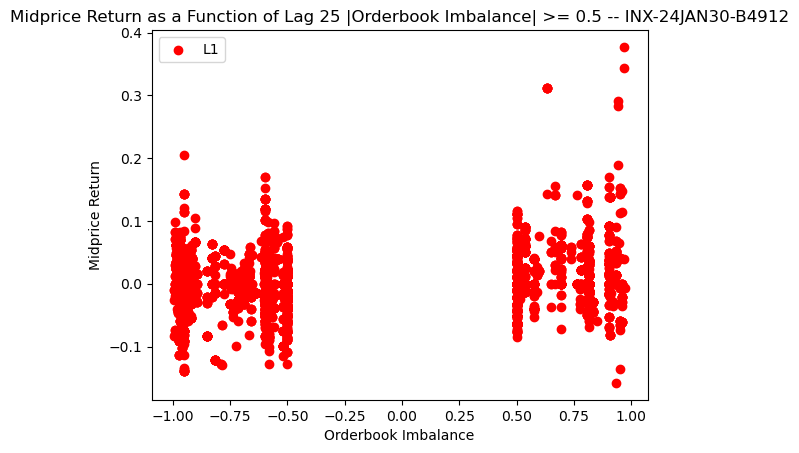

[[1.         0.13416576]
 [0.13416576 1.        ]]


In [30]:
for lookahead_period in [25]:#, 10, 15, 20, 25]:
    plt.figure()
    l1_x_temp = sp500_l1_obi[:len(sp500_midpoint)-lookahead_period]
    y_temp = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    x = []
    y = []
    
    for i in range(len(l1_x_temp)):
        if abs(l1_x_temp[i]) >= 0.5:
            x.append(l1_x_temp[i])
            y.append(y_temp[i])
    
    plt.scatter(x, y, color='red', label = 'L1')
    #plt.scatter(l2_x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} |Orderbook Imbalance| >= 0.5 -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()
    
    print(np.corrcoef(x, y))

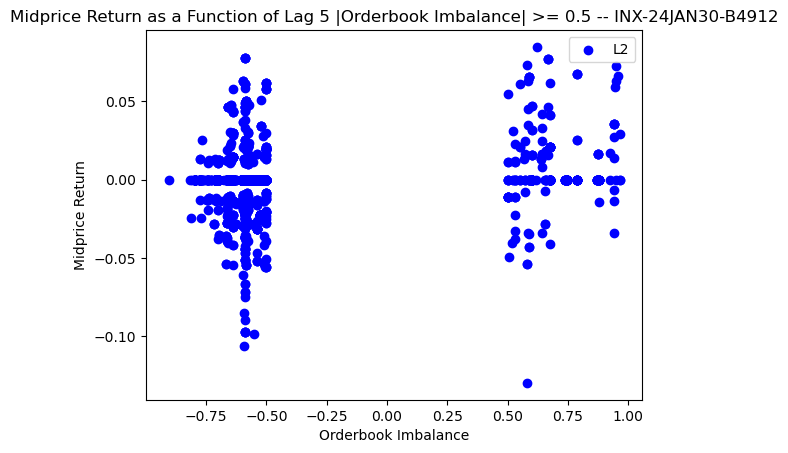

[[1.         0.16477367]
 [0.16477367 1.        ]]


In [31]:
for lookahead_period in [5]:#, 10, 15, 20, 25]:
    plt.figure()
    l2_x_temp = sp500_l2_obi[:len(sp500_midpoint)-lookahead_period]
    y_temp = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    x = []
    y = []
    
    for i in range(len(l2_x_temp)):
        if abs(l2_x_temp[i]) >= 0.5:
            x.append(l2_x_temp[i])
            y.append(y_temp[i])
    
    #plt.scatter(x, y, color='red', label = 'L1')
    plt.scatter(x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} |Orderbook Imbalance| >= 0.5 -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()
    
    print(np.corrcoef(x, y))

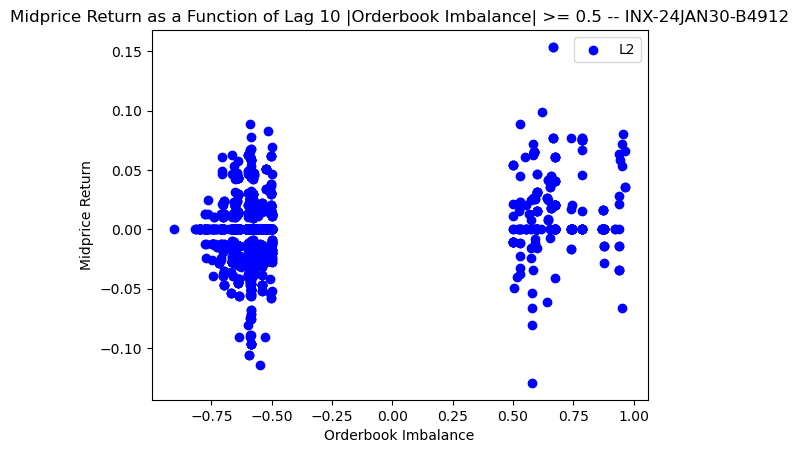

[[1.         0.21644709]
 [0.21644709 1.        ]]


In [32]:
for lookahead_period in [10]:#, 10, 15, 20, 25]:
    plt.figure()
    l2_x_temp = sp500_l2_obi[:len(sp500_midpoint)-lookahead_period]
    y_temp = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    x = []
    y = []
    
    for i in range(len(l2_x_temp)):
        if abs(l2_x_temp[i]) >= 0.5:
            x.append(l2_x_temp[i])
            y.append(y_temp[i])
    
    #plt.scatter(x, y, color='red', label = 'L1')
    plt.scatter(x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} |Orderbook Imbalance| >= 0.5 -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()
    
    print(np.corrcoef(x, y))

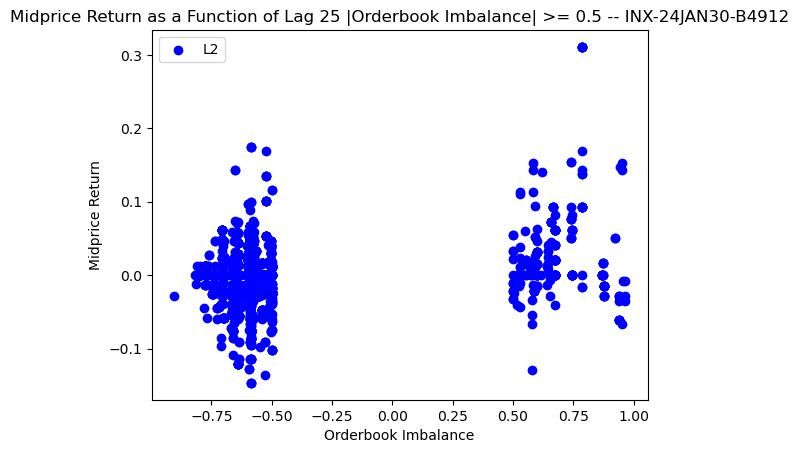

[[1.         0.26315926]
 [0.26315926 1.        ]]


In [33]:
for lookahead_period in [25]:#, 10, 15, 20, 25]:
    plt.figure()
    l2_x_temp = sp500_l2_obi[:len(sp500_midpoint)-lookahead_period]
    y_temp = (np.array(sp500_midpoint[lookahead_period:])-np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period]))/np.array(sp500_midpoint[:len(sp500_midpoint)-lookahead_period])
    
    x = []
    y = []
    
    for i in range(len(l2_x_temp)):
        if abs(l2_x_temp[i]) >= 0.5:
            x.append(l2_x_temp[i])
            y.append(y_temp[i])
    
    #plt.scatter(x, y, color='red', label = 'L1')
    plt.scatter(x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} |Orderbook Imbalance| >= 0.5 -- {}'.format(str(lookahead_period), sp500_ticker))
    plt.show()
    
    print(np.corrcoef(x, y))

In [34]:
ndx_l1_obi = data[data['ticker']==nasdaq_ticker]['obi_l1'].tolist()
ndx_l2_obi = data[data['ticker']==nasdaq_ticker]['obi_l2'].tolist()
ndx_l3_obi = data[data['ticker']==nasdaq_ticker]['obi_l3'].tolist()
ndx_l4_obi = data[data['ticker']==nasdaq_ticker]['obi_l4'].tolist()
ndx_midpoint = data[data['ticker']==nasdaq_ticker]['midpoint'].tolist()

/var/folders/8r/fr9y19j57554vvz5607f_l4h0000gn/T/ipykernel_94423/1422594894.py:4: RuntimeWarning: invalid value encountered in divide
  y_temp = (np.array(ndx_midpoint[lookahead_period:])-np.array(ndx_midpoint[:len(ndx_midpoint)-lookahead_period]))/np.array(ndx_midpoint[:len(ndx_midpoint)-lookahead_period])


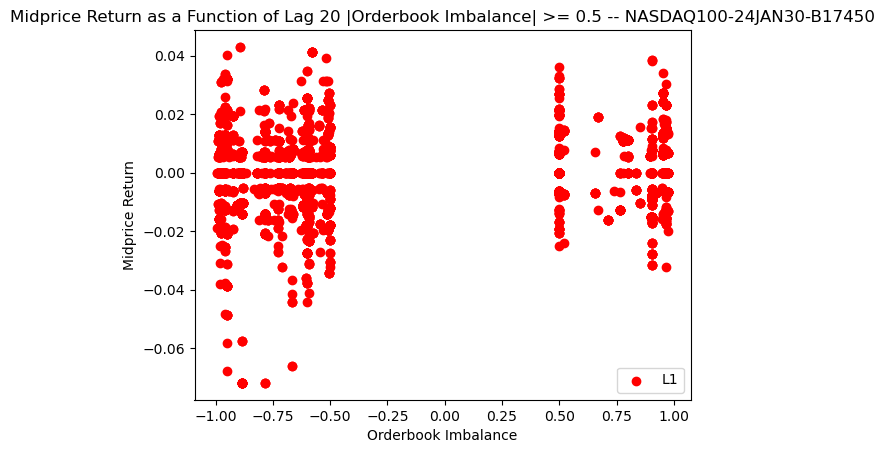

[[ 1. nan]
 [nan nan]]


In [35]:
for lookahead_period in [20]:#, 10, 15, 20, 25]:
    plt.figure()
    l1_x_temp = ndx_l1_obi[:len(ndx_midpoint)-lookahead_period]
    y_temp = (np.array(ndx_midpoint[lookahead_period:])-np.array(ndx_midpoint[:len(ndx_midpoint)-lookahead_period]))/np.array(ndx_midpoint[:len(ndx_midpoint)-lookahead_period])
    
    x = []
    y = []
    
    for i in range(len(l1_x_temp)):
        if abs(l1_x_temp[i]) >= 0.5:
            x.append(l1_x_temp[i])
            y.append(y_temp[i])
    
    plt.scatter(x, y, color='red', label = 'L1')
    #plt.scatter(l2_x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} |Orderbook Imbalance| >= 0.5 -- {}'.format(str(lookahead_period), nasdaq_ticker))
    plt.show()
    

    print(np.corrcoef(x, y))

/var/folders/8r/fr9y19j57554vvz5607f_l4h0000gn/T/ipykernel_94423/3226485699.py:4: RuntimeWarning: invalid value encountered in divide
  y_temp = (np.array(ndx_midpoint[lookahead_period:])-np.array(ndx_midpoint[:len(ndx_midpoint)-lookahead_period]))/np.array(ndx_midpoint[:len(ndx_midpoint)-lookahead_period])


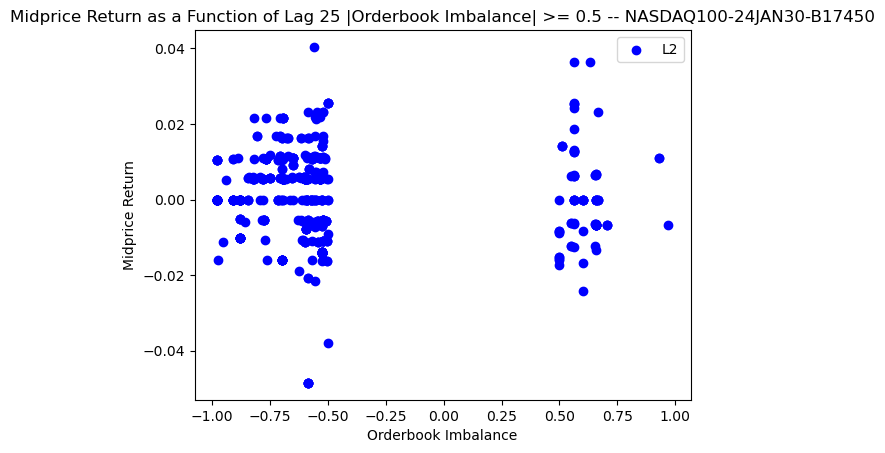

[[ 1. nan]
 [nan nan]]


In [36]:
for lookahead_period in [25]:#, 10, 15, 20, 25]:
    plt.figure()
    l2_x_temp = ndx_l2_obi[:len(ndx_midpoint)-lookahead_period]
    y_temp = (np.array(ndx_midpoint[lookahead_period:])-np.array(ndx_midpoint[:len(ndx_midpoint)-lookahead_period]))/np.array(ndx_midpoint[:len(ndx_midpoint)-lookahead_period])
    
    x = []
    y = []
    
    for i in range(len(l2_x_temp)):
        if abs(l2_x_temp[i]) >= 0.5:
            x.append(l2_x_temp[i])
            y.append(y_temp[i])
    
    #plt.scatter(x, y, color='red', label = 'L1')
    plt.scatter(x, y, color='blue', label = 'L2')
    #plt.scatter(l3_x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} |Orderbook Imbalance| >= 0.5 -- {}'.format(str(lookahead_period), nasdaq_ticker))
    plt.show()
    

    print(np.corrcoef(x, y))

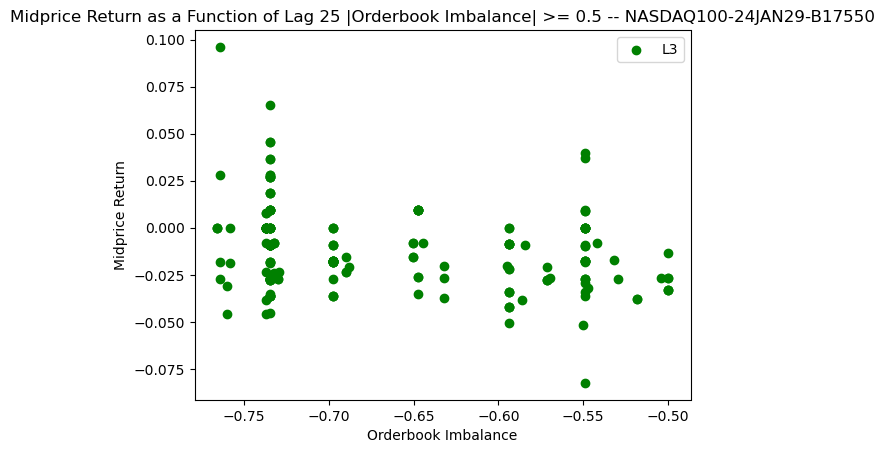

[[ 1.         -0.27357817]
 [-0.27357817  1.        ]]


In [139]:
for lookahead_period in [25]:#, 10, 15, 20, 25]:
    plt.figure()
    l3_x_temp = ndx_l3_obi[:len(ndx_midpoint)-lookahead_period]
    y_temp = (np.array(ndx_midpoint[lookahead_period:])-np.array(ndx_midpoint[:len(ndx_midpoint)-lookahead_period]))/np.array(ndx_midpoint[:len(ndx_midpoint)-lookahead_period])
    
    x = []
    y = []
    
    for i in range(len(l3_x_temp)):
        if abs(l3_x_temp[i]) >= 0.5:
            x.append(l3_x_temp[i])
            y.append(y_temp[i])
    
    #plt.scatter(x, y, color='red', label = 'L1')
    #plt.scatter(x, y, color='blue', label = 'L2')
    plt.scatter(x, y, color='green', label = 'L3')
    #plt.scatter(l4_x, y, color='black', label = 'L4')
    
    plt.legend()
    plt.xlabel('Orderbook Imbalance')
    plt.ylabel('Midprice Return')
    plt.title('Midprice Return as a Function of Lag {} |Orderbook Imbalance| >= 0.5 -- {}'.format(str(lookahead_period), nasdaq_ticker))
    plt.show()
    

    print(np.corrcoef(x, y))

The NASDAQ data on 1/29/24 seems to point to no correlation between orderbook imbalance and future returns although it could be a sample size idiosyncracy as only looking at L1 orderbook imbalance includes positive large imbalance values at all.